<a href="https://colab.research.google.com/github/NguyenLoi851/MultiLableClassification/blob/main/Naive_Bayes_with_BinaryRelevance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import library

In [ ]:
pip install scikit-multilearn

In [ ]:
# import and read csv
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ast import literal_eval
import numpy as np
import string
import re
import pandas as pd


#Pre-processing data
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

# Visualization data
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools

#Binarizer labels
from sklearn.preprocessing import MultiLabelBinarizer

#Split and vectorizer data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Train the model
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Read and filter data

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = 'https://drive.google.com/file/d/1_Qzhh4ycfWVSu_Umza8vuu92hQQXHkHC/view?usp=sharing'
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('arxiv.csv')  
  
arxiv_data = pd.read_csv('arxiv.csv')
arxiv_data.head()

,titles,summaries,terms
0,Revealing the Field Sub-subgiant Population Us...,Sub-subgiant stars (SSGs) fall below the subgi...,"['astro-ph.SR', 'astro-ph.GA']"
1,ALMA detection of ethyl cyanide and methyl for...,"In millimeter/submillimeter wavelength, the st...",['astro-ph.GA']
2,Accretion processes in the galaxy cluster Hydr...,"Clusters of galaxies evolve and accrete mass, ...","['astro-ph.CO', 'astro-ph.GA']"
3,Radio astronomy locates the neutrino origin in...,High-energy astrophysical neutrinos have been ...,"['astro-ph.HE', 'astro-ph.GA']"
4,The extragalactic $γ$-ray background: imprints...,Star-forming galaxies (SFGs) are expected to h...,"['astro-ph.GA', 'astro-ph.HE']"


In [ ]:
arxiv_data_filtered = arxiv_data

In [ ]:
# Transform raw string of labels into a list of string
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)

In [ ]:
arxiv_data_filtered["terms"].values[0]

['astro-ph.SR', 'astro-ph.GA']

In [ ]:
arxiv_data_filtered.head()

,titles,summaries,terms
0,Revealing the Field Sub-subgiant Population Us...,Sub-subgiant stars (SSGs) fall below the subgi...,"[astro-ph.SR, astro-ph.GA]"
1,ALMA detection of ethyl cyanide and methyl for...,"In millimeter/submillimeter wavelength, the st...",[astro-ph.GA]
2,Accretion processes in the galaxy cluster Hydr...,"Clusters of galaxies evolve and accrete mass, ...","[astro-ph.CO, astro-ph.GA]"
3,Radio astronomy locates the neutrino origin in...,High-energy astrophysical neutrinos have been ...,"[astro-ph.HE, astro-ph.GA]"
4,The extragalactic $γ$-ray background: imprints...,Star-forming galaxies (SFGs) are expected to h...,"[astro-ph.GA, astro-ph.HE]"


In [ ]:
arxiv_data_filtered.describe()

,titles,summaries,terms
count,43539,43539,43539
unique,33062,33077,130
top,VLBI20-30: a scientific roadmap for the next d...,This white paper describes the science case fo...,[astro-ph.GA]
freq,6,6,4639


In [ ]:
duplicated_titles = arxiv_data_filtered["titles"].duplicated().sum()
print("Số dữ liệu trùng lặp:", duplicated_titles)

Số dữ liệu trùng lặp: 10477


In [ ]:
arxiv_data_filtered = arxiv_data_filtered[~arxiv_data_filtered["titles"].duplicated()]
data_after_filtered = len(arxiv_data_filtered)
print("Số dữ liệu sau khi lọc:", data_after_filtered)

Số dữ liệu sau khi lọc: 33062


#Pre-processing data

In [ ]:
def clean_text(text):
  # remove new line characters
  text = re.sub(r"\n", " ", text)
  # remove email
  text = re.sub(r"([A-Za-z0-9_.+-]+@[A-Za-z0-9-]+\.?[A-Za-z0-9-.]+)", "", text)
  # remove url
  text = re.sub(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "", text)
  # remove punctuation
  text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
  # remove words including numbers
  text = re.sub(r"\w*\d\w*", "", text)
  # replace multiple whitespace by one whitespace
  text = re.sub(r"\s+", " ", text)
  # lower all text
  text = text.lower()
  # strip all text
  text = text.strip()
  return text

In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  cleaned_text = []
  # turn text to a list of words
  word_list = text.split()
  for word in word_list:
    if word not in stop_words:
      cleaned_text.append(word)
  return ' '.join(cleaned_text)

In [ ]:
def lemmatize_text(text):
  wnl = WordNetLemmatizer()
  pos_text = pos_tag(word_tokenize(text))
  cleaned_text = []
  for word, tag in pos_text:
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lem_word = word
    else:
      lem_word = wnl.lemmatize(word, wntag)
    cleaned_text.append(lem_word)
  return ' '.join(cleaned_text)

In [ ]:
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(clean_text)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(remove_stopwords)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(lemmatize_text)
arxiv_data_filtered['summaries']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

0        sub subgiant star ssgs fall subgiant branch re...
1        millimeter submillimeter wavelength study comp...
2        cluster galaxy evolve accrete mass mostly smal...
3        high energy astrophysical neutrino observe sev...
4        star form galaxy sfgs expect harbour abundant ...
                               ...                        
43532    investigate formation process galactic globula...
43535    non local thermodynamic equilibrium nlte level...
43536    recent study flare loop oscillation event dece...
43537    perform comprehensive study stellar population...
43538    study basic property three possible r process ...
Name: summaries, Length: 33062, dtype: object

In [ ]:
arxiv_data_filtered["summaries"][3]

'high energy astrophysical neutrino observe several telescope last decade source still remain unknown address problem locate astrophysical neutrino source statistical manner show blazars positionally associate icecube neutrino detection stronger parsec scale radio core rest sample probability chance coincidence correspond significance sigma explicitly list four strong radio blazars highly probable source neutrinos tev nrao pks pks least radio bright blazars emit neutrino lower energy start tevs use continuous ratan monitoring vlbi select blazars find radio flare frequency ghz coincide neutrino arrival date pronounce example behavior pks experience major flare demonstrate majority icecube astrophysical neutrino flux derive muon track analysis may explain blazars agns bright doppler boost jet high energy neutrino produce photohadronic interaction within parsec scale relativistic jet radio bright blazars associate neutrino detection diverse gamma ray property suggest gamma ray neutrino ma

#Visualization data

In [ ]:
all_terms = sum(arxiv_data_filtered["terms"],[])
all_terms = nltk.FreqDist(all_terms) 
# # create dataframe
all_terms_df = pd.DataFrame({'Term': list(all_terms.keys()), 
                              'Count': list(all_terms.values())})

In [ ]:
print(all_terms_df.sort_values(by = ['Count']))

          Term  Count
2  astro-ph.CO   4842
4  astro-ph.IM   6782
3  astro-ph.HE   6888
5  astro-ph.EP   8464
0  astro-ph.SR   9443
1  astro-ph.GA  10854


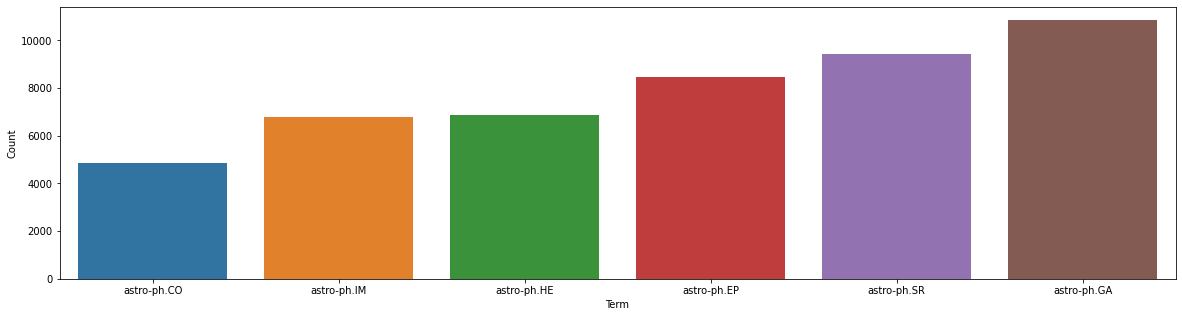

In [ ]:
g = all_terms_df.sort_values(by = ['Count'])
plt.figure(figsize=(20,5)) 
ax = sns.barplot(data=g, y= "Count", x = "Term") 
plt.show()

In [ ]:
print((arxiv_data_filtered["terms"].value_counts()[1:20]))

[astro-ph.EP]                 4571
[astro-ph.HE]                 3559
[astro-ph.SR]                 3062
[astro-ph.IM]                 2832
[astro-ph.CO]                 2258
[astro-ph.EP, astro-ph.SR]    1241
[astro-ph.SR, astro-ph.GA]    1026
[astro-ph.GA, astro-ph.CO]     913
[astro-ph.GA, astro-ph.SR]     752
[astro-ph.SR, astro-ph.EP]     680
[astro-ph.HE, astro-ph.GA]     554
[astro-ph.CO, astro-ph.GA]     541
[astro-ph.EP, astro-ph.IM]     492
[astro-ph.HE, astro-ph.SR]     448
[astro-ph.GA, astro-ph.HE]     417
[astro-ph.IM, astro-ph.HE]     405
[astro-ph.IM, astro-ph.EP]     358
[astro-ph.SR, astro-ph.HE]     357
[astro-ph.HE, astro-ph.IM]     331
Name: terms, dtype: int64


#Binary Relevance

##Train the model
*Vectorizer by TFIDF*

###Split and vectorizer by Tfidf

In [ ]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(arxiv_data_filtered.terms)

In [ ]:
vocab = list(mlb.classes_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    arxiv_data_filtered['summaries'],
    labels,
    test_size = 0.2,
    )

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26449,)
(6613,)
(26449, 6)
(6613, 6)


In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
vectorizer.fit(X_test)
X_train_vector = vectorizer.transform(X_train)
X_test_vector = vectorizer.transform(X_test)

###Train the model with MultinomialNB and evaluate 

In [ ]:
# initialize binary relevance multi-label classifier
# with a multinomial naive bayes base classifier
model = BinaryRelevance(MultinomialNB())

model.fit(X_train_vector, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
print(y_pred_prob.shape)

(6613, 6)


In [ ]:
def get_y_pred(y_pred_prob, k=3, threshold=0.5):
    y_pred = []
    for pred in y_pred_prob:
        top_k_labels = [
            x
            for _,x in sorted(
                zip(pred, vocab),
                key=lambda pair: pair[0],
                reverse=True,
            )
        ][:k]
        y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
        for j in range(len(vocab)):
            if(vocab[j] in top_k_labels):
                if(pred[j] > threshold):
                    y_top_k_labels[j] = 1
                else:
                    top_k_labels.remove(vocab[j])
        y_pred.append(y_top_k_labels)
    y_pred = np.array(y_pred)   
    return y_pred


In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 57.33% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 57.16% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 56.74% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 55.33% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 53.46% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 50.6% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 46.29% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 40.12% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 37.88% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 51.75% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 57.86% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on 

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.7)
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5676    8]
 [ 578  351]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4848   18]
 [ 503 1244]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4426   49]
 [ 918 1220]]

multilabel_confusion_matrix_of: astro-ph.HE
[[5191   13]
 [ 741  668]]

multilabel_confusion_matrix_of: astro-ph.IM
[[5206   55]
 [ 612  740]]

multilabel_confusion_matrix_of: astro-ph.SR
[[4636   37]
 [1234  706]]



In [ ]:
print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.98      0.38      0.55       929
 astro-ph.EP       0.99      0.71      0.83      1747
 astro-ph.GA       0.96      0.57      0.72      2138
 astro-ph.HE       0.98      0.47      0.64      1409
 astro-ph.IM       0.93      0.55      0.69      1352
 astro-ph.SR       0.95      0.36      0.53      1940

   micro avg       0.96      0.52      0.67      9515
   macro avg       0.96      0.51      0.66      9515
weighted avg       0.96      0.52      0.67      9515
 samples avg       0.70      0.60      0.63      9515



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Train the model with BernoulliNB and evaluate

In [ ]:
# initialize binary relevance multi-label classifier
# with a bernoulli naive bayes base classifier
model = BinaryRelevance(BernoulliNB())

model.fit(X_train_vector, y_train)

BinaryRelevance(classifier=BernoulliNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 57.01% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 56.99% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 56.95% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 56.95% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 56.93% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 56.89% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 56.84% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 56.77% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 45.65% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 47.33% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 48.33% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.7)
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5256  428]
 [ 160  769]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4689  177]
 [ 127 1620]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4131  344]
 [ 446 1692]]

multilabel_confusion_matrix_of: astro-ph.HE
[[4886  318]
 [ 176 1233]]

multilabel_confusion_matrix_of: astro-ph.IM
[[4824  437]
 [ 210 1142]]

multilabel_confusion_matrix_of: astro-ph.SR
[[4001  672]
 [ 353 1587]]



In [ ]:
print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.64      0.83      0.72       929
 astro-ph.EP       0.90      0.93      0.91      1747
 astro-ph.GA       0.83      0.79      0.81      2138
 astro-ph.HE       0.79      0.88      0.83      1409
 astro-ph.IM       0.72      0.84      0.78      1352
 astro-ph.SR       0.70      0.82      0.76      1940

   micro avg       0.77      0.85      0.81      9515
   macro avg       0.77      0.85      0.80      9515
weighted avg       0.78      0.85      0.81      9515
 samples avg       0.81      0.89      0.82      9515



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Tran the model
*Vectorizer by CountVectorizer*

###Vectorizer by CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
vectorizer.fit(X_test)
X_train_vector = vectorizer.transform(X_train)
X_test_vector = vectorizer.transform(X_test)

###Train the model with MultinomialNB and evaluate

In [ ]:
# initialize binary relevance multi-label classifier
# with a multinomial naive bayes base classifier
model = BinaryRelevance(MultinomialNB())

model.fit(X_train_vector, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 56.54% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 56.54% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 56.53% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 56.51% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 56.51% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 56.49% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 56.49% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 56.46% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 48.04% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 48.86% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 49.36% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.5)
from sklearn.metrics import multilabel_confusion_matrix
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5169  515]
 [ 127  802]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4665  201]
 [ 109 1638]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4106  369]
 [ 405 1733]]

multilabel_confusion_matrix_of: astro-ph.HE
[[4841  363]
 [ 160 1249]]

multilabel_confusion_matrix_of: astro-ph.IM
[[4796  465]
 [ 194 1158]]

multilabel_confusion_matrix_of: astro-ph.SR
[[3963  710]
 [ 313 1627]]



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.61      0.86      0.71       929
 astro-ph.EP       0.89      0.94      0.91      1747
 astro-ph.GA       0.82      0.81      0.82      2138
 astro-ph.HE       0.77      0.89      0.83      1409
 astro-ph.IM       0.71      0.86      0.78      1352
 astro-ph.SR       0.70      0.84      0.76      1940

   micro avg       0.76      0.86      0.81      9515
   macro avg       0.75      0.87      0.80      9515
weighted avg       0.77      0.86      0.81      9515
 samples avg       0.80      0.91      0.82      9515



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Train the model with BernoulliNB and valuate

In [ ]:
# initialize binary relevance multi-label classifier
# with a bernoulli naive bayes base classifier
model = BinaryRelevance(BernoulliNB())

model.fit(X_train_vector, y_train)

BinaryRelevance(classifier=BernoulliNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
print(y_pred_prob)

[[5.94779776e-08 2.00789238e-10 2.84601649e-10 9.99999998e-01
  1.57095093e-02 6.52265540e-09]
 [5.27019123e-08 1.68842311e-10 9.99999999e-01 3.51484116e-01
  1.57162075e-15 1.64169496e-01]
 [1.63491403e-14 5.44798337e-24 1.00000000e+00 9.99991630e-01
  2.85831328e-28 1.64292443e-04]
 ...
 [1.16449509e-21 4.29659714e-01 1.00000000e+00 1.20984713e-16
  2.12397269e-18 1.00000000e+00]
 [1.31557640e-11 2.34518937e-26 1.00000000e+00 7.58544630e-05
  1.57374233e-32 2.26635909e-12]
 [7.03501656e-22 2.43844850e-20 6.97459503e-03 1.00000000e+00
  6.97970343e-25 1.00000000e+00]]


In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 57.01% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 56.99% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 56.95% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 56.95% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 56.93% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 56.89% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 56.84% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 56.77% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 45.65% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 47.33% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 48.33% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.5)
from sklearn.metrics import multilabel_confusion_matrix
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5233  451]
 [ 154  775]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4676  190]
 [ 121 1626]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4110  365]
 [ 426 1712]]

multilabel_confusion_matrix_of: astro-ph.HE
[[4864  340]
 [ 169 1240]]

multilabel_confusion_matrix_of: astro-ph.IM
[[4792  469]
 [ 204 1148]]

multilabel_confusion_matrix_of: astro-ph.SR
[[3939  734]
 [ 330 1610]]



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.63      0.83      0.72       929
 astro-ph.EP       0.90      0.93      0.91      1747
 astro-ph.GA       0.82      0.80      0.81      2138
 astro-ph.HE       0.78      0.88      0.83      1409
 astro-ph.IM       0.71      0.85      0.77      1352
 astro-ph.SR       0.69      0.83      0.75      1940

   micro avg       0.76      0.85      0.80      9515
   macro avg       0.76      0.85      0.80      9515
weighted avg       0.77      0.85      0.81      9515
 samples avg       0.80      0.90      0.81      9515



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
